In [2]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [58]:
import matplotlib.pyplot as plt
from skimage import color
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import os
import numpy as np
from PIL import Image

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

#PCA for feature reduction - Note: I tried it because it made the model fit faster
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [60]:
#path = 'C:/dataset/'
path = 'W:/Concordia/Summer2024/AI/test/images/training'

In [62]:
classes = ["Bar", "Casino", "Restaurant", "Library", "Hospital"]

def load_images(data_path, classes):
    data = []
    labels = []
    for class_n in classes:
        path = os.path.join(data_path, class_n)
        l = classes.index(class_n)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
#                 img = plt.imread(img_path)  #This is for using skimage
                img = Image.open(img_path)
                if img.mode != 'RGB':
                    print("Not rgb")
                    continue
                img = img.resize((256,256))
                img = np.array(img)
                data.append(img)
                labels.append(l)
            except Exception as e:
                print(f"Error : {e}")
    return np.array(data), np.array(labels)

X, y = load_images(path, classes)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.18, stratify=y, random_state=42)

In [66]:
# Flattening
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

PCA
scaler = StandardScaler()
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(scaler.fit_transform(X_train_flat))
X_test_pca = pca.transform(scaler.transform(X_test_flat))

# X_train_pca = X_train_flat
# X_test_pca = X_test_flat

In [68]:
# #parameter tuning
# best_accuracy = 0
# best_params = {}
# for max_depth in [10, 20, 30, None]:
#     for min_samples_split in [2, 10, 20]:
#         for min_samples_leaf in [1, 5, 10]:
#             dt = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=42)
#             dt.fit(X_train_pca, y_train)
#             y_pred = dt.predict(X_test_pca)
#             accuracy = accuracy_score(y_test, y_pred)
#             if accuracy > best_accuracy:
#                 best_accuracy = accuracy
#                 best_params = {'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}

# print(best_params)

# dt = DecisionTreeClassifier(**best_params,random_state=42)
# dt.fit(X_train_pca, y_train)
# y_pred = dt.predict(X_test_pca)

In [70]:
#parameter tuning - Pruning
best_accuracy = 0
best_params = {}
for max_depth in [10, 15, 20, 30]:
    for min_samples_split in [2, 10, 20]:
        for min_samples_leaf in [1, 5, 10]:
            for ccp_alpha in [0.0, 0.01, 0.05, 0.1]: # Added ccp_alpha for pruning
                dt = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, ccp_alpha=ccp_alpha, random_state=42)
                dt.fit(X_train_pca, y_train)
                y_pred = dt.predict(X_test_pca)
                accuracy = accuracy_score(y_test, y_pred)
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params = {'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'ccp_alpha': ccp_alpha}

print(best_params)



{'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'ccp_alpha': 0.0}


In [71]:
dt = DecisionTreeClassifier(**best_params,random_state=42)
dt.fit(X_train_pca, y_train)
y_pred = dt.predict(X_test_pca)

In [72]:
# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=classes)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.3791304347826087
Classification Report:
              precision    recall  f1-score   support

         Bar       0.25      0.29      0.27       109
      Casino       0.56      0.64      0.60       117
  Restaurant       0.32      0.29      0.30       115
     Library       0.27      0.20      0.23       108
    Hospital       0.44      0.44      0.44       126

    accuracy                           0.38       575
   macro avg       0.37      0.37      0.37       575
weighted avg       0.37      0.38      0.37       575



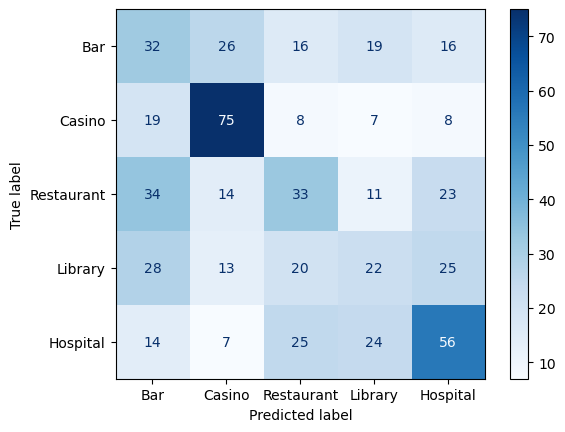

In [73]:
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes).plot(cmap=plt.cm.Blues)
plt.show()

In [78]:
print("Supervised done.")

Supervised done.


In [236]:
#split the labelled data for semi-supervised learning in 20:80 ratio
#prev : X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.18, stratify=y, random_state=42)
X_train_labeled, X_train_unlabeled, y_train_labeled, y_train_unlabeled = train_test_split(
    X_train, y_train, test_size=0.6, stratify=y_train, random_state=42
)

In [238]:
#unlabel the data
y_train_unlabeled = np.full(y_train_unlabeled.shape, -1)

In [240]:
# Flattening
X_train_labeled_flat = X_train_labeled.reshape(X_train_labeled.shape[0], -1)
X_train_unlabeled_flat = X_train_unlabeled.reshape(X_train_unlabeled.shape[0], -1)

PCA
scaler = StandardScaler()
pca = PCA(n_components=100)
X_train_labeled_pca = pca.fit_transform(scaler.fit_transform(X_train_labeled_flat))
X_train_unlabeled_pca = pca.transform(scaler.transform(X_train_unlabeled_flat))

In [242]:
#parameter tuning - Pruning
best_accuracy = 0
best_params = {}
for max_depth in [10, 15, 20, 30]:
    for min_samples_split in [2, 10, 20]:
        for min_samples_leaf in [1, 5, 10]:
            for ccp_alpha in [0.0, 0.01, 0.05, 0.1]: # Added ccp_alpha for pruning
                base_estimator = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, ccp_alpha=ccp_alpha, random_state=42)
                base_estimator.fit(X_train_labeled_pca, y_train_labeled)
                y_pred = dt.predict(X_train_unlabeled_pca)
                accuracy = accuracy_score(y_train_unlabeled, y_pred)
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params = {'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'ccp_alpha': ccp_alpha}

print(best_params)

{}


In [244]:
base_estimator = DecisionTreeClassifier(random_state=42)

In [246]:
#self-training constraints
threshold = 0.95
max_iterations = 30

In [248]:
#convert labeled data to lists to allow dynamic addition of confident labeled data
X_labeled = list(X_train_labeled_pca)
y_labeled = list(y_train_labeled)

In [250]:
#start iterations for predicting data
for iteration in range(max_iterations):
    base_estimator.fit(X_labeled,y_labeled)

    # Check if there are samples left to predict
    if X_train_unlabeled_pca.shape[0] == 0:
        break
    
    probabilities = base_estimator.predict_proba(X_train_unlabeled_pca)
    max_probabilities = np.max(probabilities, axis = 1)

    # Identify confident predictions
    confident_prediction_index = np.where(max_probabilities >= threshold)[0]

    # Break if no confident predictions
    if len(confident_prediction_index) == 0:
        break

    # Add confident predictions to the labeled set
    X_confident = X_train_unlabeled_pca[confident_prediction_index]
    y_confident = base_estimator.predict(X_confident)
    
    X_labeled.extend(X_confident)
    y_labeled.extend(y_confident)

    # Remove confident samples from the unlabeled set
    X_train_unlabeled_pca = np.delete(X_train_unlabeled_pca, confident_prediction_index, axis=0)    

In [252]:
# Fit the classifier on the final labeled data
base_estimator.fit(X_labeled, y_labeled)

DecisionTreeClassifier(random_state=42)

In [254]:
y_pred = base_estimator.predict(X_test_pca)

In [256]:
# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=classes)
conf_matrix_semi_sup = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.24695652173913044
Classification Report:
              precision    recall  f1-score   support

         Bar       0.17      0.17      0.17       109
      Casino       0.38      0.28      0.32       117
  Restaurant       0.18      0.19      0.19       115
     Library       0.22      0.25      0.24       108
    Hospital       0.31      0.33      0.32       126

    accuracy                           0.25       575
   macro avg       0.25      0.24      0.25       575
weighted avg       0.25      0.25      0.25       575



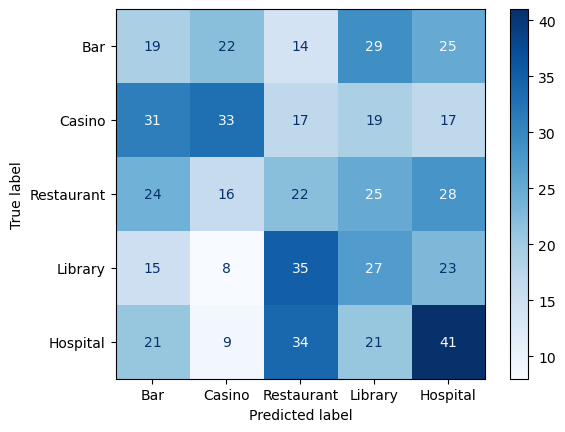

In [258]:
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_semi_sup, display_labels=classes).plot(cmap=plt.cm.Blues)
plt.show()